**The purpose of this notebook is to explore hyperparameter optimization of the RandomForestClassifier used in our machine learning pipeline.**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.ensemble
import sklearn.feature_selection
import unittest

import sklearn.datasets
import sklearn.tree

import optuna

Gonna test this out with and without feature engineering.

In [3]:
#convert to pandas df
df = pd.read_csv('learn2therm_sample_50k_exploration.csv')

In [4]:
cd /Users/loganroberts/Learn2Therm/ValidProt/notebooks

/Users/loganroberts/Learn2Therm/ValidProt/notebooks


In [5]:
target = pd.read_csv('protein_match_6k.csv')

In [6]:
target.head()

prot_pair_index  Jaccard_Score protein_match
0         48641291            1.0           Yes
1         92992745            1.0           Yes
2        157628663            1.0           Yes
3        136708305            1.0           Yes
4        133672542            1.0           Yes

In [7]:
df.head()

Unnamed: 0  local_gap_compressed_percent_id  scaled_local_query_percent_id  \
0           0                         0.287582                       0.217822   
1           1                         0.319635                       0.295359   
2           2                         0.279621                       0.234127   
3           3                         0.327273                       0.200743   
4           4                         0.338710                       0.318182   

   scaled_local_symmetric_percent_id  query_align_len  query_align_cov  \
0                           0.215686              160         0.792079   
1                           0.297872              218         0.919831   
2                           0.218924              211         0.837302   
3                           0.214712              166         0.617100   
4                           0.287671               60         0.909091   

   subject_align_len  subject_align_cov  bit_score  thermo_index  ...  \
0                152           0.737864        131           875  ...   
1                226           0.969957        282         11324  ...   
2                210           0.731707         96           875  ...   
3                163           0.696581        175           875  ...   
4                 71           0.887500         61          9827  ...   

   bit_score_16s  m_ogt  t_ogt  ogt_difference  \
0         1153.0   27.5   50.0            22.5   
1         1014.0   25.0   54.0            29.0   
2         1138.0   28.0   50.0            22.0   
3         1077.0   28.0   50.0            22.0   
4          991.0   30.0   50.0            20.0   

                                       m_protein_seq  \
0  MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...   
1  MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...   
2  MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...   
3  MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...   
4  MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...   

                                       t_protein_seq  \
0  MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...   
1  MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...   
2  MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...   
3  MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...   
4  MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...   

                                      m_protein_desc  \
0               ECF RNA polymerase sigma factor SigK   
1            response regulator transcription factor   
2                          SDR family oxidoreductase   
3  ectoine/hydroxyectoine ABC transporter permeas...   
4                                YqzK family protein   

                                t_protein_desc  m_protein_len  t_protein_len  
0  sigma-70 family RNA polymerase sigma factor            206            202  
1      response regulator transcription factor            233            237  
2                    SDR family oxidoreductase            287            252  
3          amino acid ABC transporter permease            234            269  
4                          YqzK family protein             80             66  

[5 rows x 30 columns]

In [9]:
df = pd.merge(df, target, on=['prot_pair_index'])
df.shape

(6348, 32)

In [10]:
df['protein_match'].value_counts()

Yes    5243
No     1105
Name: protein_match, dtype: int64

In [11]:
#get rid of stuff that isn't quantitative

df = df.drop(columns = ['Unnamed: 0','thermo_index', 'm_protein_seq', 't_protein_seq',
                        'm_protein_desc', 't_protein_desc'])

In [13]:
df.head()

local_gap_compressed_percent_id  scaled_local_query_percent_id  \
0                         0.287582                       0.217822   
1                         0.319635                       0.295359   
2                         0.279621                       0.234127   
3                         0.327273                       0.200743   
4                         0.338710                       0.318182   

   scaled_local_symmetric_percent_id  query_align_len  query_align_cov  \
0                           0.215686              160         0.792079   
1                           0.297872              218         0.919831   
2                           0.218924              211         0.837302   
3                           0.214712              166         0.617100   
4                           0.287671               60         0.909091   

   subject_align_len  subject_align_cov  bit_score  meso_index  \
0                152           0.737864        131       12897   
1                226           0.969957        282       13026   
2                210           0.731707         96        8203   
3                163           0.696581        175        3340   
4                 71           0.887500         61       14020   

   prot_pair_index  ...  query_align_cov_16s  subject_align_cov_16s  \
0         48641291  ...             0.998040               0.998020   
1         92992745  ...             1.000000               1.000000   
2        157628663  ...             1.000000               1.000000   
3        136708305  ...             0.996734               0.996726   
4        133672542  ...             0.998084               0.998067   

   bit_score_16s  m_ogt  t_ogt  ogt_difference  m_protein_len  t_protein_len  \
0         1153.0   27.5   50.0            22.5            206            202   
1         1014.0   25.0   54.0            29.0            233            237   
2         1138.0   28.0   50.0            22.0            287            252   
3         1077.0   28.0   50.0            22.0            234            269   
4          991.0   30.0   50.0            20.0             80             66   

   Jaccard_Score  protein_match  
0            1.0            Yes  
1            1.0            Yes  
2            1.0            Yes  
3            1.0            Yes  
4            1.0            Yes  

[5 rows x 26 columns]

from pairplot below, it looks like query_align_cov_16s and subject_align_cov_16s dont correlate with anything

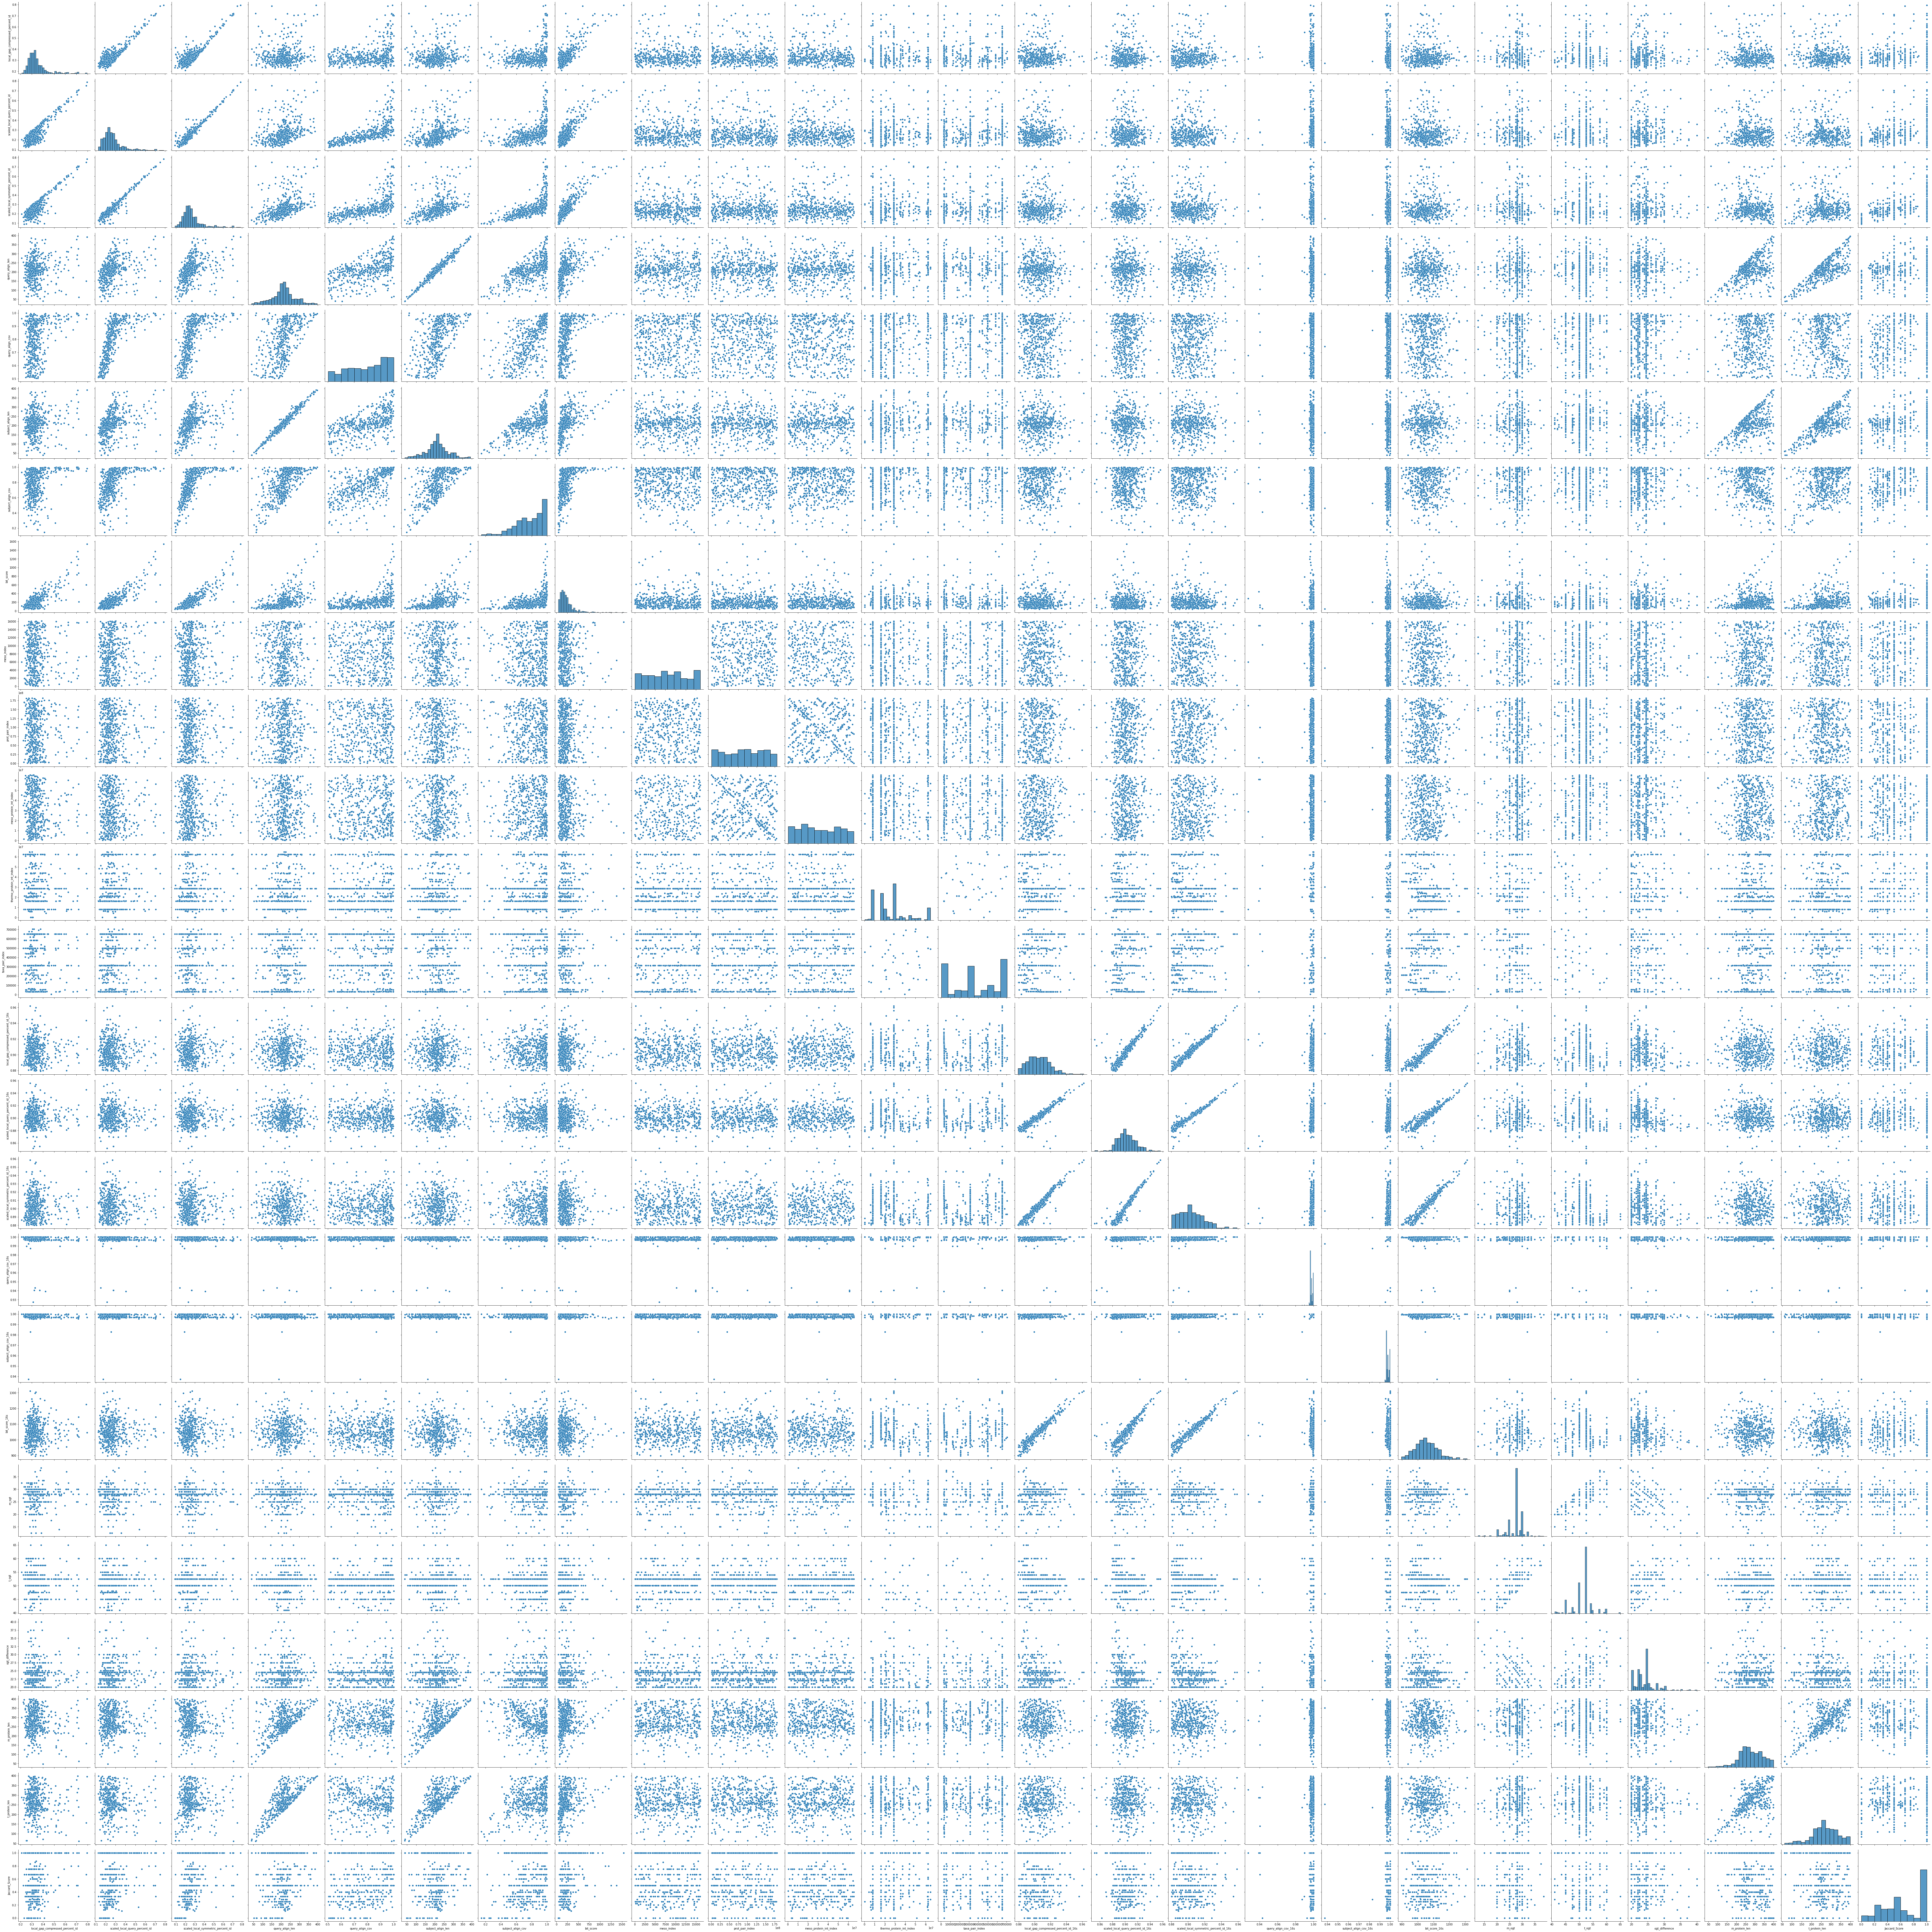

In [14]:
sns.pairplot(df.sample(500),height = 4)

In [15]:
df = df.drop(columns = ['query_align_cov_16s', 'subject_align_cov_16s', 'Jaccard_Score'])
df.columns

Index(['local_gap_compressed_percent_id', 'scaled_local_query_percent_id',
       'scaled_local_symmetric_percent_id', 'query_align_len',
       'query_align_cov', 'subject_align_len', 'subject_align_cov',
       'bit_score', 'meso_index', 'prot_pair_index', 'meso_protein_int_index',
       'thermo_protein_int_index', 'taxa_pair_index',
       'local_gap_compressed_percent_id_16s',
       'scaled_local_query_percent_id_16s',
       'scaled_local_symmetric_percent_id_16s', 'bit_score_16s', 'm_ogt',
       't_ogt', 'ogt_difference', 'm_protein_len', 't_protein_len',
       'protein_match'],
      dtype='object')

In [16]:
#describe dataframe
df.describe()

local_gap_compressed_percent_id  scaled_local_query_percent_id  \
count                      6348.000000                    6348.000000   
mean                          0.348174                       0.276047   
std                           0.096390                       0.113913   
min                           0.193431                       0.106383   
25%                           0.292571                       0.205948   
50%                           0.323720                       0.250000   
75%                           0.366709                       0.306723   
max                           0.959350                       0.951613   

       scaled_local_symmetric_percent_id  query_align_len  query_align_cov  \
count                        6348.000000      6348.000000      6348.000000   
mean                            0.270881       208.339162         0.792409   
std                             0.115180        63.261682         0.145697   
min                             0.066929        23.000000         0.327935   
25%                             0.203093       176.000000         0.672716   
50%                             0.244565       211.000000         0.811727   
75%                             0.300314       241.000000         0.925000   
max                             0.955466       398.000000         1.000000   

       subject_align_len  subject_align_cov    bit_score    meso_index  \
count        6348.000000        6348.000000  6348.000000   6348.000000   
mean          207.604600           0.773547   233.339162   8098.207152   
std            63.264993           0.175379   186.940699   4565.102004   
min            23.000000           0.083916    37.000000      5.000000   
25%           176.000000           0.657086   121.000000   4243.250000   
50%           210.000000           0.805808   188.000000   8046.000000   
75%           240.000000           0.924258   270.000000  12069.000000   
max           398.000000           1.000000  1565.000000  16345.000000   

       prot_pair_index  ...  taxa_pair_index  \
count     6.348000e+03  ...      6348.000000   
mean      9.059579e+07  ...    355550.743856   
std       5.250268e+07  ...    229185.300466   
min       8.858000e+03  ...      4917.000000   
25%       4.530101e+07  ...    160014.250000   
50%       9.085625e+07  ...    312289.000000   
75%       1.360285e+08  ...    583839.000000   
max       1.814286e+08  ...    744518.000000   

       local_gap_compressed_percent_id_16s  scaled_local_query_percent_id_16s  \
count                          6348.000000                        6348.000000   
mean                              0.906858                           0.903284   
std                               0.015076                           0.015491   
min                               0.876590                           0.851713   
25%                               0.896167                           0.893115   
50%                               0.906052                           0.902487   
75%                               0.915845                           0.912476   
max                               0.999351                           0.993544   

       scaled_local_symmetric_percent_id_16s  bit_score_16s        m_ogt  \
count                            6348.000000    6348.000000  6348.000000   
mean                                0.904973    1061.527725    27.399023   
std                                 0.015208      75.487037     3.683267   
min                                 0.880026     891.000000     7.000000   
25%                                 0.893493    1009.000000    27.500000   
50%                                 0.903723    1055.000000    28.000000   
75%                                 0.914471    1107.250000    29.000000   
max                                 0.996439    1618.000000    40.000000   

             t_ogt  ogt_difference  m_protein_len  t_protein_len  
count  6348.000000     6348.000000    6348.000000    6348.000000

Split dev and test data:

In [17]:
df = df.drop(columns = ['meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference'])

In [18]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

#might want to name the above split train/val, since we don't really have "test data" yet
train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)
print(train.shape)
print(val.shape)

(5395, 11)
(953, 11)
(4585, 11)
(810, 11)


In [19]:
target = 'protein_match'
input_features = [columns for columns in df]
input_features.remove(target)

In [20]:
print(input_features)
print(target)

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
protein_match


In [21]:
# predicting values 

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target].values.reshape(-1,1)
test_y = test[target].values.reshape(-1,1)  

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(5395, 10) (953, 10) (5395, 1) (953, 1)


In [22]:
train_X = train[input_features].values
val_X = val[input_features].values

train_y = train[target].values.reshape(-1,1)
val_y = val[target].values.reshape(-1,1) 

Scale the data

In [23]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

Train the model

In [24]:
#Random Forest
#hyperparameters determined from optimization below

model = sklearn.ensemble.RandomForestClassifier(n_estimators=150, max_depth=None, max_samples=0.5,
                                                max_features=0.5, min_weight_fraction_leaf=0.000215,
                                               min_samples_split=10)
model.fit(dev_X, dev_y.ravel())

RandomForestClassifier(max_features=0.5, max_samples=0.5, min_samples_split=10,
                       min_weight_fraction_leaf=0.000215, n_estimators=150)

Test the model, report relevant statistics

In [26]:
score = model.score(test_X, test_y)
print('Model score is: {}'.format(score))

preds = model.predict(test_X)

Model score is: 0.8342077649527807


In the cell below, try bagging to improve accuracy of the model.

In [27]:
#try bagging

from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(sklearn.ensemble.RandomForestClassifier(n_estimators=200, max_depth=None, min_weight_fraction_leaf=0.000215),
                             max_samples=0.5, max_features=0.5)

In [28]:
bagging.fit(dev_X, dev_y.ravel())

BaggingClassifier(estimator=RandomForestClassifier(min_weight_fraction_leaf=0.000215,
                                                   n_estimators=200),
                  max_features=0.5, max_samples=0.5)

In [29]:
bagging.score(test_X, test_y)

0.8310598111227702

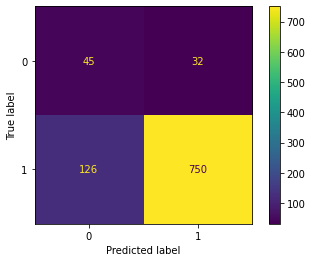

In [30]:
#confusion matrix

confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

Try Random Search to optimize hyperparameters

In [31]:
# create hyperparameter value options for each hyperparameter
max_depth_options = [1,2,3,4,5]
min_weight_fraction_options = [0, 0.1, 0.2, 0.3, 0.4]
max_sample_options = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
min_samples_split_options = [i for i in range(20)]

In [32]:
# Define the grid of hyperparameter options

param_grid = {
    'max_depth': max_depth_options,
    'min_weight_fraction_leaf': min_weight_fraction_options,
    'n_estimators': [i for i in range(0,300,10)],
#     'n_estimators': [0,25,50,75,100,125,150,175,200,225,250,275,300],
    'min_samples_split': min_samples_split_options,
    'max_samples': max_sample_options
}

# Create the grid search object
# Give it the model we want to use, the hyperparameters to search over
#CV parameter executes k-fold cross validation

random_search = sklearn.model_selection.RandomizedSearchCV(
    sklearn.ensemble.RandomForestClassifier(),
    param_grid,
    cv=5
)
# execute the grid search
random_search.fit(dev_X, dev_y.ravel())

print('Best hyperparameters: ', random_search.best_params_)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pac

Best hyperparameters:  {'n_estimators': 150, 'min_weight_fraction_leaf': 0, 'min_samples_split': 16, 'max_samples': 0.2, 'max_depth': 3}


In [34]:
# model = sklearn.ensemble.RandomForestClassifier(n_estimators=190, max_depth=None, min_weight_fraction_leaf=0,
#                              max_samples=0.3, max_features=0.5, min_samples_split=11)
# model.fit(dev_X, dev_y.ravel())
# print(model.score(test_X, test_y))

In [35]:
model = sklearn.ensemble.RandomForestClassifier(n_estimators=150, max_depth=3, min_weight_fraction_leaf=0,
                             max_samples=0.2, max_features=0.5, min_samples_split=16)
model.fit(dev_X, dev_y.ravel())
print(model.score(test_X, test_y))

0.8352570828961176


^^^ about the same when compared to original hyperparameters

Optimize hyperparameters with Optuna

In [44]:
def train_evaluate_hyperparameters(max_depth, min_weight_fraction_leaf, n_estimators, min_samples_split):
    
    # create RF classifier model
    model = sklearn.ensemble.RandomForestClassifier(max_depth=max_depth, min_weight_fraction_leaf=min_weight_fraction_leaf,
                                               n_estimators=n_estimators, min_samples_split=min_samples_split)
    
    # train the model on the training set
    fit = model.fit(train_X, train_y)
    
    # evaluate the model on the validation set
    score = model.score(val_X, val_y)
    
    return score

In [46]:
def id_best_hyperparams(trial):
    # define hyperparameter space
    max_depth_options = trial.suggest_int('max_depth_options', 1, 5)
    min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
    n_estimator_options = trial.suggest_int('n_estimators', 50, 200, 50)
    min_samples_split_options = trial.suggest_int('min_samples_split', 1, 20, 2)
    
    # get the score for the hyperparameters chosen
    score = train_evaluate_hyperparameters(max_depth=max_depth_options, min_weight_fraction_leaf=min_weight_fraction_options,
                                          n_estimators=n_estimator_options, min_samples_split=min_samples_split_options)
    
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(id_best_hyperparams, n_trials=50)
print('Best params: ', study.best_params)

[I 2023-04-29 12:29:28,993] A new study created in memory with name: no-name-6763b0e3-f1ac-4ec6-b056-b5fc01bc9a8d
<ipython-input-46-2df51d1c07c6>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
<ipython-input-44-e797ad6282fb>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = model.fit(train_X, train_y)
[I 2023-04-29 12:29:29,368] Trial 0 finished with value: 0.7950617283950617 and parameters: {'max_depth_options': 3, 'min_weight_fraction_options': 0.37990949012342695, 'n_estimators': 150, 'min_samples_split': 11}. Best is trial 0 with value: 0.7950617283950617.
<ipython-input-46-2df51d1c07c6>:4: FutureWarning: sugg

[I 2023-04-29 12:29:32,947] Trial 7 finished with value: 0.7950617283950617 and parameters: {'max_depth_options': 4, 'min_weight_fraction_options': 0.06787196955168705, 'n_estimators': 100, 'min_samples_split': 11}. Best is trial 6 with value: 0.8135802469135802.
<ipython-input-46-2df51d1c07c6>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
<ipython-input-44-e797ad6282fb>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[I 2023-04-29 12:29:35,807] Trial 15 finished with value: 0.7950617283950617 and parameters: {'max_depth_options': 5, 'min_weight_fraction_options': 0.12971013502381395, 'n_estimators': 150, 'min_samples_split': 15}. Best is trial 8 with value: 0.8160493827160494.
<ipython-input-46-2df51d1c07c6>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
<ipython-input-44-e797ad6282fb>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chang

[I 2023-04-29 12:29:39,241] Trial 23 finished with value: 0.7950617283950617 and parameters: {'max_depth_options': 3, 'min_weight_fraction_options': 0.07226765604814461, 'n_estimators': 150, 'min_samples_split': 19}. Best is trial 21 with value: 0.817283950617284.
<ipython-input-46-2df51d1c07c6>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
<ipython-input-44-e797ad6282fb>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chang

[I 2023-04-29 12:29:43,471] Trial 31 finished with value: 0.8148148148148148 and parameters: {'max_depth_options': 3, 'min_weight_fraction_options': 0.02728429975837237, 'n_estimators': 200, 'min_samples_split': 11}. Best is trial 21 with value: 0.817283950617284.
<ipython-input-46-2df51d1c07c6>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
<ipython-input-44-e797ad6282fb>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chang

[I 2023-04-29 12:29:47,931] Trial 39 finished with value: 0.7950617283950617 and parameters: {'max_depth_options': 2, 'min_weight_fraction_options': 0.2763604535923738, 'n_estimators': 200, 'min_samples_split': 15}. Best is trial 21 with value: 0.817283950617284.
<ipython-input-46-2df51d1c07c6>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
<ipython-input-44-e797ad6282fb>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[I 2023-04-29 12:29:52,772] Trial 47 finished with value: 0.8135802469135802 and parameters: {'max_depth_options': 4, 'min_weight_fraction_options': 0.044624722561333686, 'n_estimators': 150, 'min_samples_split': 15}. Best is trial 21 with value: 0.817283950617284.
<ipython-input-46-2df51d1c07c6>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  min_weight_fraction_options = trial.suggest_uniform("min_weight_fraction_options", 0,0.4)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
<ipython-input-44-e797ad6282fb>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

Best params:  {'max_depth_options': 2, 'min_weight_fraction_options': 0.027111086746866964, 'n_estimators': 150, 'min_samples_split': 19}


In [47]:
#try above suggestions

model = sklearn.ensemble.RandomForestClassifier(n_estimators=150, max_depth=2, min_weight_fraction_leaf=0.027111086746866964,
                             max_samples=0.2, max_features=0.5, min_samples_split=19)
model.fit(dev_X, dev_y.ravel())
print(model.score(test_X, test_y))

0.8352570828961176


Let's try with engineered features.